<a href="https://colab.research.google.com/github/Mayank1325/Customer-Analytics/blob/main/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Cakestands and Paper Birdies: Cohort Analysis of UK E-Commerce in Python

As e-commerce continues to grow at a rapid pace, traditional brick and mortar establishments are focusing on their online efforts to keep up with leaders like Amazon. Walmart's recent entry and purchase of Jet.com have driven growth substantially, with US e-commerce increasing 40% in the second quarter of 2018.

For e-commerce establishments, cohort analysis plays an important role in understanding sales figures and customers. Cohort analysis refers to the separation of customers into "cohorts" based on their acquisition date or date of first purchase.

The subsequent activity of each cohort can then be tracked to gain deeper insight into key customer metrics such as customer lifetime value and retention rates. Customer lifetime value refers to the total expected profit you expect to gain from that customer across all future interactions. Retention rate refers to the percentage of original customers retained after each time period.

With this analysis, I hope to address two key questions:

How do you interpret and clean e-commerce data?
How do you create a simple cohort analysis to compare metrics across cohorts?
The dataset used here was drawn from the UCI Data Repository and contains 541,909 transactions of a UK-based non-store retail that sells all-occassion gifts.

In [ ]:
import pandas as pd
import seaborn as sb
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from textwrap import wrap

In [ ]:
online_data=pd.read_excel("/content/Online Retail.xlsx")

In [ ]:
online_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
online_data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
online_data.shape

(541909, 8)

In [ ]:
online_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
online_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:

main_df = online_data
main_df.columns = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price', 'cust_id','country']
main_df['tot_order'] = main_df['quantity']*main_df['unit_price']
main_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


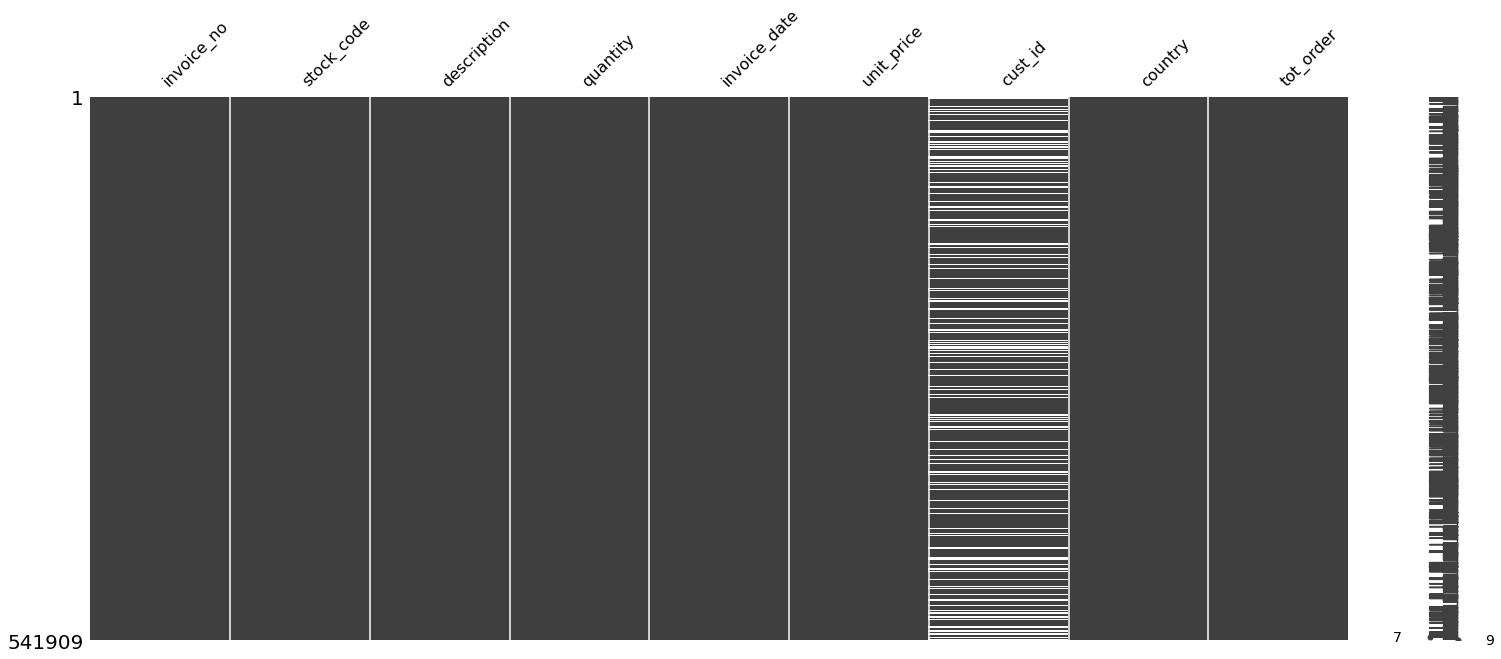

In [ ]:
msno.matrix(main_df)

Missing values

A quick visualization with missingno indicates that there are quite a few missing fields for customer ids. As we need to identify specific customers to place them in cohorts, we will have to drop the orders with missing customer ids.

In [12]:
main_df = main_df[main_df['cust_id'].isna() == False]
# main_df.reset_index()
# main_df.drop(['index'], axis = 1, inplace=True)
main_df.shape

(406829, 9)

A look at the quantity values also reveal some negative values. These can be intepreted as refunds. As refunds could be interesting for analyses later, we save them in a separate dataframe and remove them from the main dataframe.

As total the quantity and total order values of refunds and the original purchase cancel out when the dataframe is grouped and aggregated later, specific matching orders do not have to be identified

In [13]:
refund_df = main_df[main_df['tot_order'] < 0]
refund_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96


Outliers
How about outliers in the data? Are there abnormally large order amounts?

A look at the distribution for quantity and unit price show that the majority of values are in single digits. There however seems to be outliers of up to 80,995 for order quantity and 38,970 for unit price.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


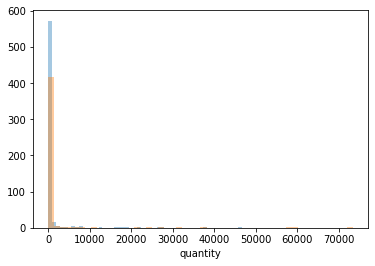

In [14]:
plt = sb.distplot(main_df['unit_price'].value_counts(), kde = False)
plt = sb.distplot(main_df['quantity'].value_counts(), kde = False)

In [15]:
main_df[['quantity', 'unit_price', 'tot_order']].describe()

,quantity,unit_price,tot_order
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854
std,248.693370,69.315162,427.591718
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.200000
50%,5.000000,1.950000,11.100000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


In [16]:
main_df[(main_df['quantity'] > 1000) & (main_df['tot_order'] > 5000)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,6539.40
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


In [17]:
main_df.groupby('description').mean()['unit_price'].nlargest()

description
DOTCOM POSTAGE                    744.147500
PICNIC BASKET WICKER 60 PIECES    649.500000
CRUK Commission                   495.839375
Manual                            334.425634
REGENCY MIRROR WITH SHUTTERS      156.428571
Name: unit_price, dtype: float64

In [20]:

main_df[main_df['description'] == 'DOTCOM POSTAGE']['unit_price'].describe()

count      16.000000
mean      744.147500
std       540.829708
min        11.170000
25%       389.082500
50%       715.850000
75%       998.635000
max      1599.260000
Name: unit_price, dtype: float64

In [19]:
main_df[main_df['description'] == 'DOTCOM POSTAGE'].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,878.55


In [21]:
main_df[main_df['description'] == 'CRUK Commission']['unit_price'].describe()

count      16.000000
mean      495.839375
std       364.164786
min         1.600000
25%       284.252500
50%       471.770000
75%       668.977500
max      1100.440000
Name: unit_price, dtype: float64

In [22]:
main_df[main_df['description'] == 'CRUK Commission'].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096.0,United Kingdom,-1.60
324023,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096.0,United Kingdom,-13.01
333779,C566216,CRUK,CRUK Commission,-1,2011-09-09 15:17:00,15.96,14096.0,United Kingdom,-15.96
338848,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096.0,United Kingdom,-52.24
351003,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096.0,United Kingdom,-608.66


'Manual' is a product that is rather nebulous. There are 465 records of Manual, with a single record commanding a unit price of 38,970. As we do not have specific information regarding the operations of this online retail company, I am making a guess that 'Manual' refers to manual services rendered with the purchase of other items. This could be the setting up of chandeliers or the shelves in a warehouse. As there are significant outliers for these transactions that do not directly tie to individual product sales, we will drop 'Manual' records too.

In [24]:

main_df[main_df['description'] == 'Manual']['unit_price'].describe()

count      465.000000
mean       334.425634
std       1935.070401
min          0.000000
25%          0.850000
50%          3.000000
75%        106.400000
max      38970.000000
Name: unit_price, dtype: float64

In [25]:
main_df[(main_df['description'] == 'Manual') & (main_df['unit_price'] > 3000)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,-6930.00
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.00
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,-4287.63
271151,C560647,M,Manual,-1,2011-07-20 11:31:00,3060.60,18102.0,United Kingdom,-3060.60
293842,C562647,M,Manual,-1,2011-08-08 12:56:00,3155.95,15502.0,United Kingdom,-3155.95
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom,3155.95
406404,C571750,M,Manual,-1,2011-10-19 11:16:00,3949.32,12744.0,Singapore,-3949.32
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore,3949.32
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France,4161.06
422375,C573079,M,Manual,-2,2011-10-27 14:15:00,4161.06,12536.0,France,-8322.12


'Discount' seems to be a rather self explanatory category for discounts offered for products sold. This is further corroborated by the fact that all these transactions have negative sales quantities. As discounts directly tie into the price of products and impact sales directly, we will leave it in the dataframe.

In [26]:
main_df[main_df['description'] == 'Discount']['unit_price'].describe()

count      77.000000
mean       72.484545
std       219.271071
min         0.010000
25%        13.880000
50%        22.970000
75%        57.600000
max      1867.860000
Name: unit_price, dtype: float64

In [27]:
main_df[main_df['description'] == 'Discount'].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,-29.29
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,-281.00
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,-267.12
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,-5.76


In [28]:
removed_cats = ['DOTCOM POSTAGE', 'CRUK Commission', 'Manual', 'POSTAGE']
main_df = main_df[~main_df['description'].isin(removed_cats)]
main_df.shape

(405136, 9)

In [29]:
main_df.groupby(['country','description']).sum()['tot_order'].nlargest(10)

country         description                       
United Kingdom  REGENCY CAKESTAND 3 TIER              103122.85
                WHITE HANGING HEART T-LIGHT HOLDER     88313.95
                JUMBO BAG RED RETROSPOT                75416.67
                PARTY BUNTING                          61952.58
                ASSORTED COLOUR BIRD ORNAMENT          52314.87
                CHILLI LIGHTS                          45155.61
                PICNIC BASKET WICKER 60 PIECES         39619.50
                PAPER CHAIN KIT 50'S CHRISTMAS         39596.73
                BLACK RECORD COVER FRAME               37799.42
                WOOD BLACK BOARD ANT WHITE FINISH      33408.76
Name: tot_order, dtype: float64

In [30]:

main_df.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
cust_id                float64
country                 object
tot_order              float64
dtype: object

Total orders per country

In [47]:
import matplotlib.pyplot as plt


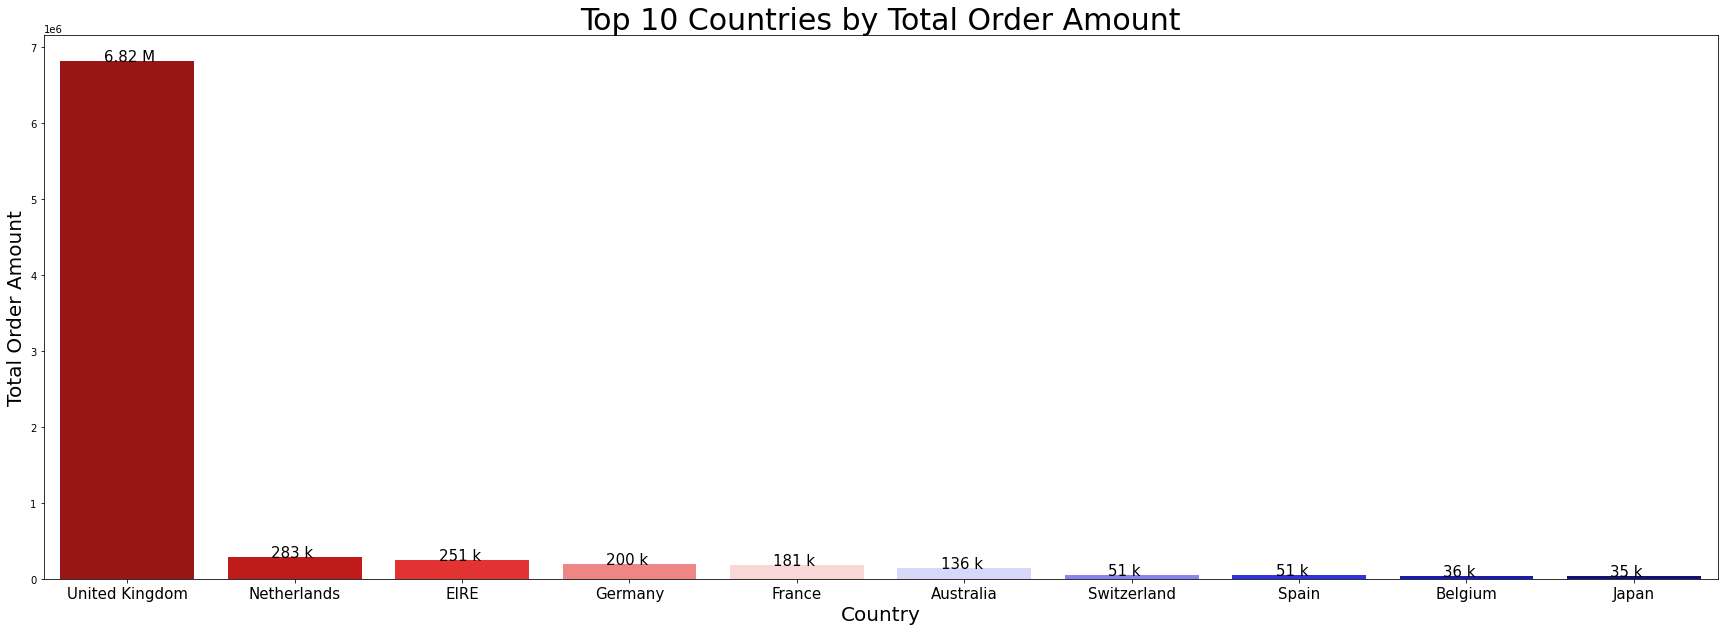

In [49]:
country_order = main_df.groupby('country').sum()['tot_order'].nlargest(10)

plt.figure(figsize = (30,10))
ax = sb.barplot(x = country_order.index, y = country_order.values, palette = 'seismic_r')
ax.set_xlabel('Country', fontsize = 20)
ax.set_ylabel('Total Order Amount', fontsize = 20)
ax.set_title('Top 10 Countries by Total Order Amount', fontsize = 30)

labels = [ '\n'.join(wrap(l, 15)) for l in country_order.index ]
ax.set_xticklabels(labels, fontsize = 15)

value_labels = []
for x in country_order.values:
    value_labels.append(str(int(x/1000))+' k')
value_labels[0] = '6.82 M'


for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.26, p.get_height() + 2), fontsize = 15)

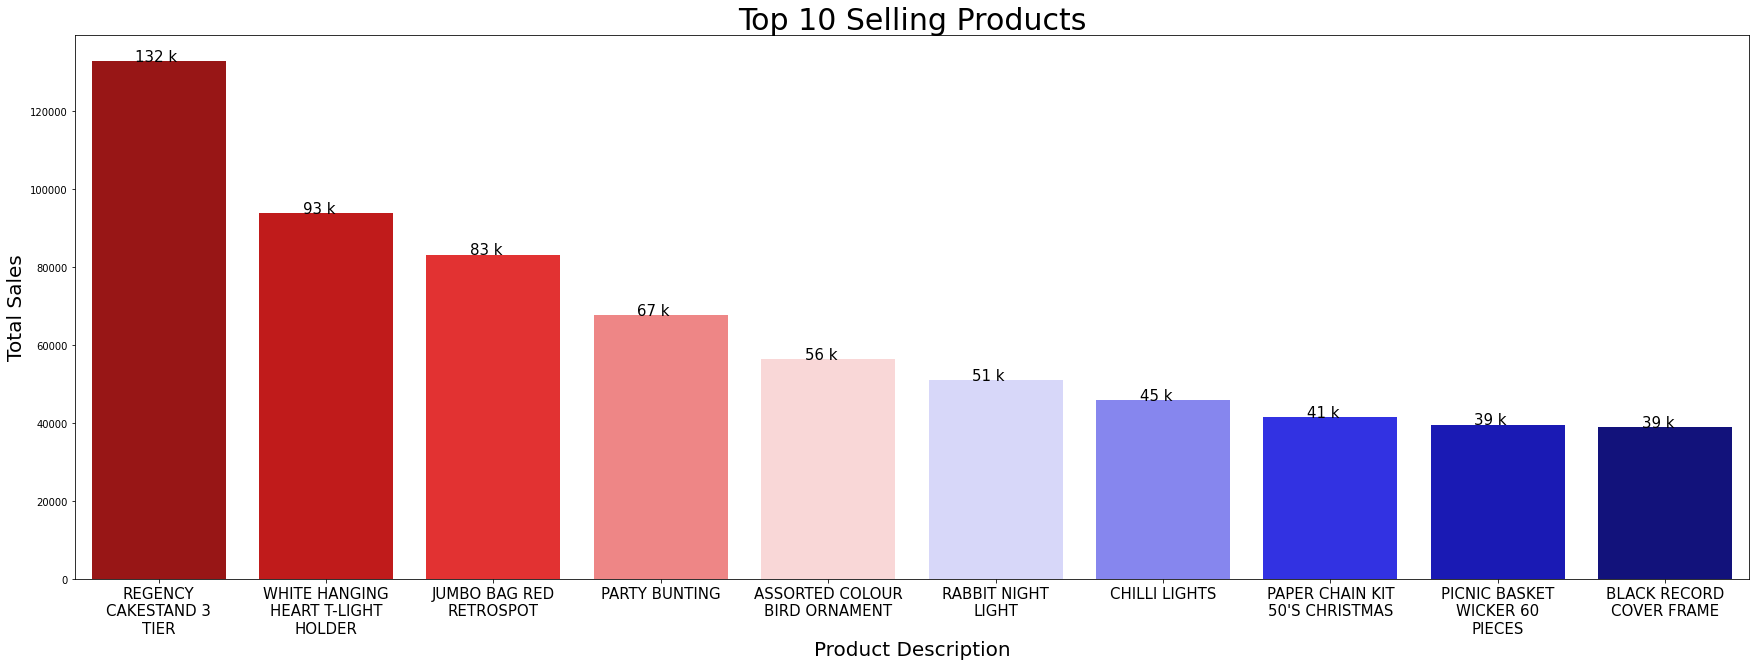

In [50]:
sales_order = main_df.groupby('description').sum()['tot_order'].nlargest(10)

plt.figure(figsize = (30,10))
ax = sb.barplot(x = sales_order.index, y = sales_order.values, palette = 'seismic_r')
ax.set_xlabel('Product Description', fontsize = 20)
ax.set_ylabel('Total Sales', fontsize = 20)
ax.set_title('Top 10 Selling Products', fontsize = 30)

labels = [ '\n'.join(wrap(l, 15)) for l in sales_order.index ]
ax.set_xticklabels(labels, fontsize = 15)

value_labels = []
for x in sales_order.values:
    value_labels.append(str(int(x/1000))+' k')

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.26, p.get_height() + 2), fontsize = 15)


**LABEL FOR INVOICE PERIOD**

In [51]:
main_df['invoice_period'] = main_df['invoice_date'].apply(lambda x: x.strftime('%Y-%m'))
main_df.head() 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,tot_order,invoice_period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [52]:
invoice_period_grouped = main_df.groupby('invoice_period')
invoice_period_agg = invoice_period_grouped.agg({'cust_id': pd.Series.nunique,
                       'description': pd.Series.nunique,
                      'quantity': np.sum,
                      'tot_order': np.sum})
invoice_period_agg.rename(columns ={'cust_id':'total_customers',
                         'description':'total_product_types',
                        'quantity':'total_units'}, inplace = True)
invoice_period_agg

,total_customers,total_product_types,total_units,tot_order
invoice_period,,,,
2010-12,948.0,2427,295957,549996.100
2011-01,780.0,2149,269139,472914.850
2011-02,794.0,2140,262820,434945.260
2011-03,1017.0,2248,343999,575002.240
2011-04,896.0,2234,278383,420368.331
2011-05,1077.0,2266,369059,651910.230
2011-06,1049.0,2366,356669,641967.370
2011-07,982.0,2390,363193,581676.861
2011-08,977.0,2395,386998,613232.000


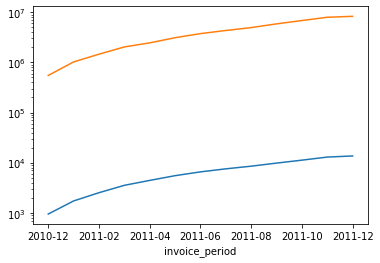

In [53]:
ax = invoice_period_agg['total_customers'].cumsum().plot()
ax2 = invoice_period_agg['tot_order'].cumsum().plot()
ax.set_yscale('log')

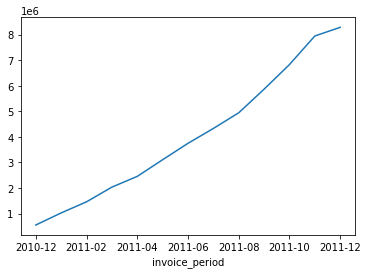

In [54]:
invoice_period_agg['tot_order'].cumsum().plot()

**LABEL FOR CUSTOMER COHORT GROUP**

As we do not have a sign up date for customers, we give them cohort labels based on their first purchase during this period of time. To do this, we group the transactions by customers and find the minimum of the invoice date. This will be the earliest purchase. The same strftime function is applied to create the new label for cohort group.

In [55]:
main_df.set_index('cust_id', inplace = True)
main_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,tot_order,invoice_period
cust_id,,,,,,,,,
17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12
17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12
17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12


In [56]:
main_df['cohort_group'] = main_df.groupby(level=0)['invoice_date'].min().apply(lambda x: x.strftime('%Y-%m'))
main_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,tot_order,invoice_period,cohort_group
cust_id,,,,,,,,,,
17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12


In [57]:
main_df.reset_index(inplace = True)
main_df.head()

,cust_id,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,tot_order,invoice_period,cohort_group
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
2,17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
3,17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
4,17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12


**Aggregate Metrics across cohort groups and invoice periods**

Now that we have the labels for when a customer first made a purchase and when individual purchases occured, we can now create some aggregate metrics to represent each time period.

We count the total number of customers and products sold in a period by their unique ids and descriptions. We then sum the quantities sold and total invoice amount to get the aggregate sales figures for the periods.

In [58]:
grouped = main_df.groupby(['cohort_group','invoice_period'])
cohorts = grouped.agg({'cust_id': pd.Series.nunique,
                       'description': pd.Series.nunique,
                      'quantity': np.sum,
                      'tot_order': np.sum})
cohorts.rename(columns ={'cust_id':'total_customers',
                         'description':'total_product_types',
                        'quantity':'total_units'}, inplace = True)
cohorts.head()

total_customers  ...  tot_order
cohort_group invoice_period                   ...           
2010-12      2010-12                   948.0  ...  549996.10
             2011-01                   361.0  ...  269782.69
             2011-02                   316.0  ...  230727.57
             2011-03                   366.0  ...  300720.43
             2011-04                   340.0  ...  199453.49

[5 rows x 4 columns]

**Label for Invoice Period within cohort groups**

For cohort analysis, it is imperative to identify purchases across the lifetime of this customer. For example, if a customer joined 5 months ago, we would need labels from 1-5 to identify metrics across each month.

We create this label by first grouping our previous cohorts object by 'cohort_group'. We then find the length of each group and create a list to represent this range with np.arange(). For example, np.arange(5) returns [0, 1, 2, 3, 4].

As we want this list to start with 1, we add 1 to every number in this range.

In [59]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_customers  ...  cohort_period
cohort_group invoice_period                   ...               
2010-12      2010-12                   948.0  ...              1
             2011-01                   361.0  ...              2
             2011-02                   316.0  ...              3
             2011-03                   366.0  ...              4
             2011-04                   340.0  ...              5

[5 rows x 5 columns]

**User retention**

Text(0.5, 1.0, 'Retention Rates Across Cohorts')

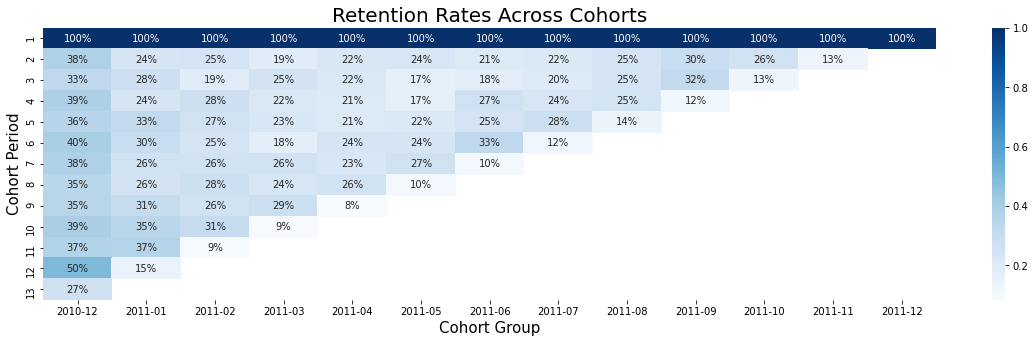

In [60]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

cohort_sizes = cohorts.groupby(level=0)['total_customers'].first()
user_retention = cohorts['total_customers'].unstack(0).divide(cohort_sizes, axis = 1)
plt.figure(figsize=(20,5))
ax = sb.heatmap(user_retention, annot=True,cmap='Blues', fmt='.0%')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Retention Rates Across Cohorts', fontsize = 20)

Text(0.5, 1.0, 'Monthly Total Sales Across Cohorts')

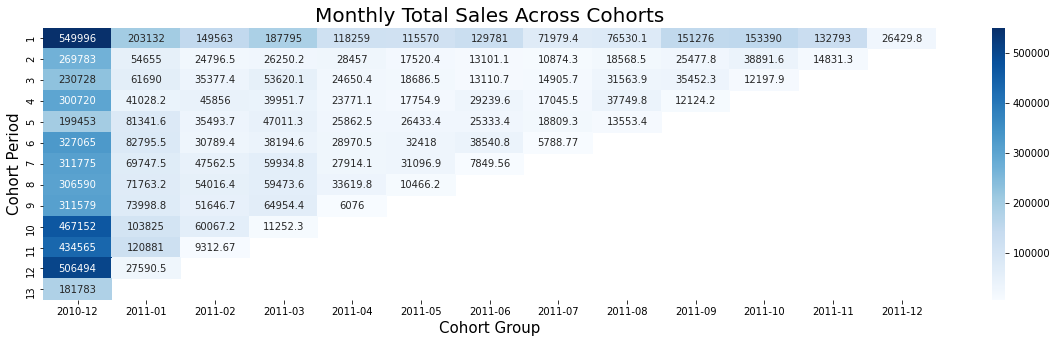

In [61]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

unstacked_order = cohorts['tot_order'].unstack(0)
plt.figure(figsize=(20,5))
ax = sb.heatmap(unstacked_order, annot=True,cmap='Blues', fmt='g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Total Sales Across Cohorts', fontsize = 20)

Text(0.5, 1.0, 'Monthly Active Customers Across Cohorts')

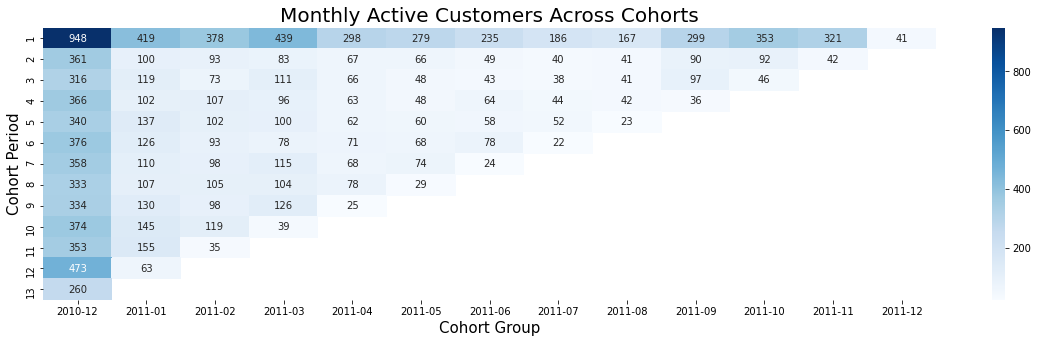

In [62]:
unstacked_cust = cohorts['total_customers'].unstack(0)
plt.figure(figsize=(20,5))
ax = sb.heatmap(unstacked_cust, annot = True, cmap='Blues', fmt = 'g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Active Customers Across Cohorts', fontsize = 20)

# Refunds and Cancellations

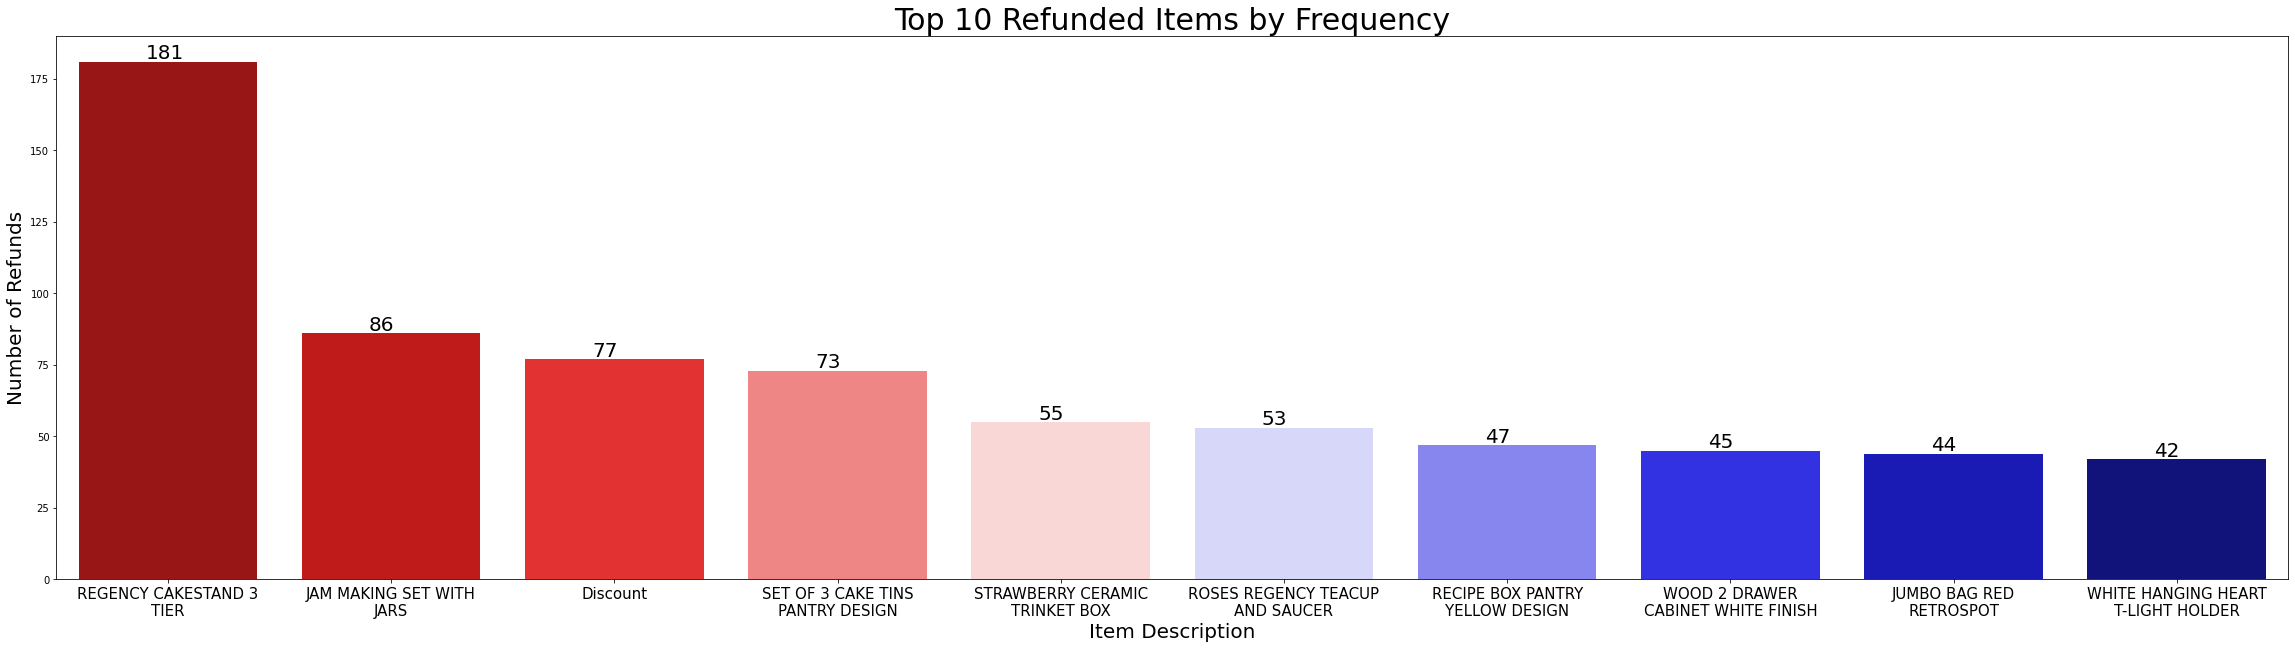

In [63]:
refund_df = refund_df[~refund_df['description'].isin(removed_cats)]

plt.figure(figsize = (40,10))
ax = sb.barplot(x = refund_df['description'].value_counts().nlargest(10).index, y = refund_df['description'].value_counts().nlargest(10).values, palette = 'seismic_r')
ax.set_xlabel('Item Description', fontsize = 20)
ax.set_ylabel('Number of Refunds', fontsize = 20)
ax.set_title('Top 10 Refunded Items by Frequency', fontsize = 30)

labels = [ '\n'.join(wrap(l, 20)) for l in refund_df['description'].value_counts().nlargest(10).index ]
ax.set_xticklabels(labels, fontsize = 15)

for p, label in zip(ax.patches, refund_df['description'].value_counts().nlargest(10).values):
    ax.annotate(label, (p.get_x() + 0.3, p.get_height() + 1), fontsize = 20)

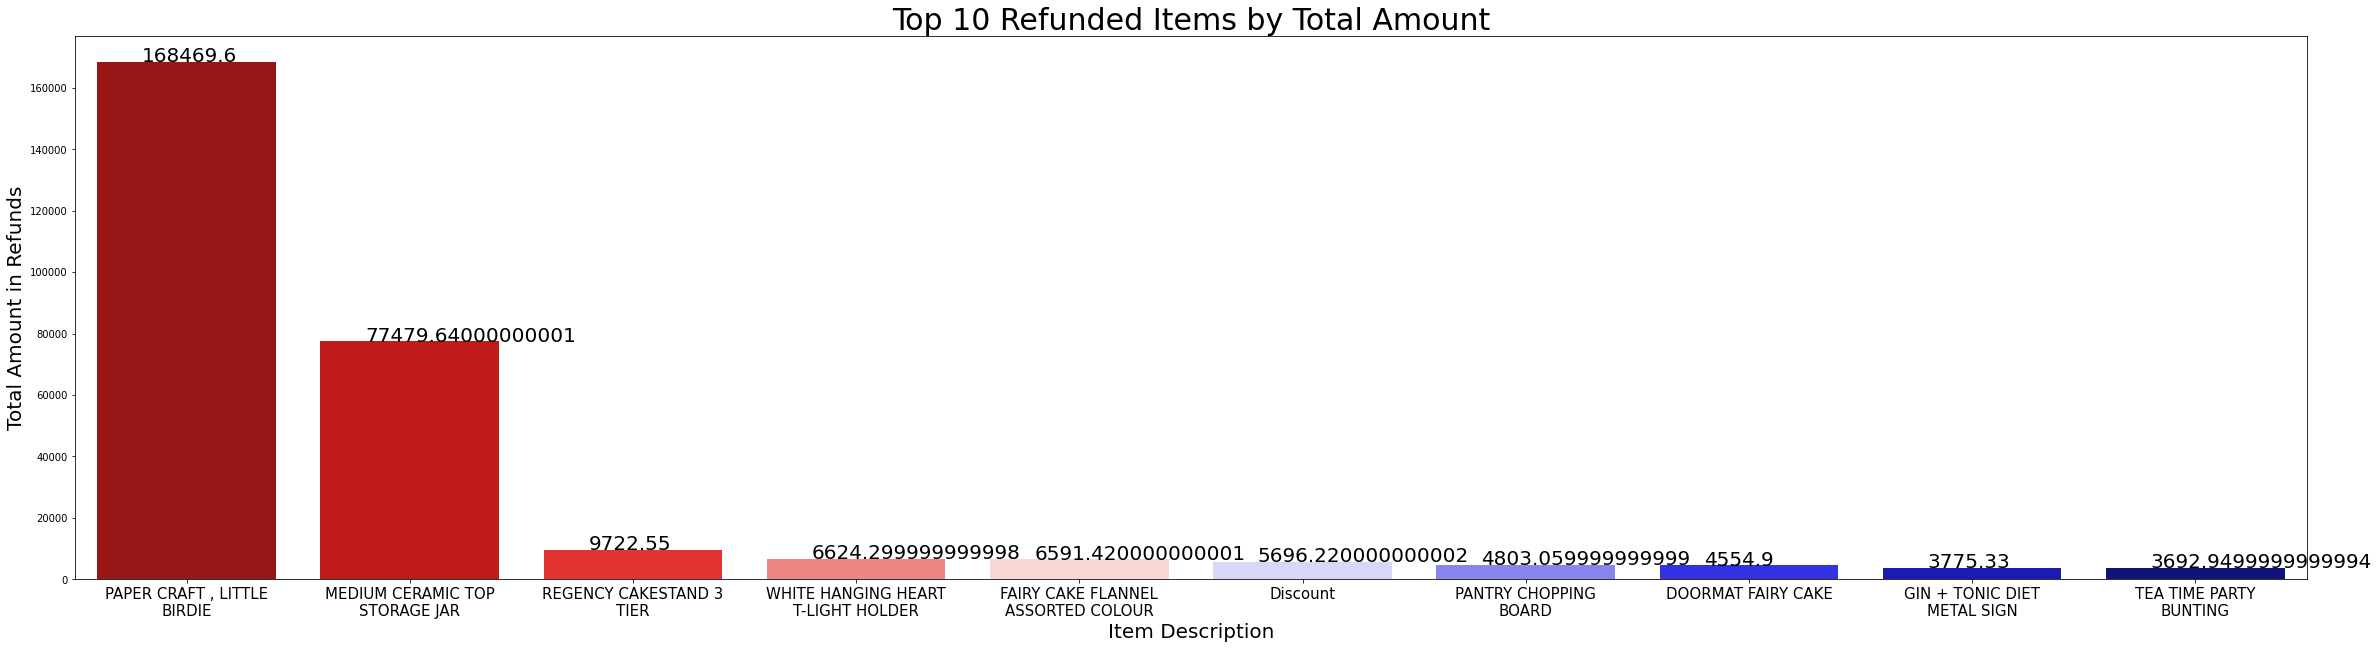

In [64]:
top_refund_amt = -refund_df.groupby('description').sum()['tot_order'].nsmallest(10)

plt.figure(figsize = (40,10))
ax = sb.barplot(x = top_refund_amt.index, y = top_refund_amt.values, palette = 'seismic_r')
ax.set_xlabel('Item Description', fontsize = 20)
ax.set_ylabel('Total Amount in Refunds', fontsize = 20)
ax.set_title('Top 10 Refunded Items by Total Amount', fontsize = 30)

labels = [ '\n'.join(wrap(l, 20)) for l in top_refund_amt.index ]
ax.set_xticklabels(labels, fontsize = 15)

for p, label in zip(ax.patches, top_refund_amt.values):
    ax.annotate(label, (p.get_x() + 0.2, p.get_height() + 10), fontsize = 20)

In [65]:
large_refunds = refund_df['tot_order'].nsmallest(10).index
for refund in large_refunds:
    print(-refund_df.loc[refund]['quantity'], ' units of ', refund_df.loc[refund]['description'], ' refunded at ', -refund_df.loc[refund]['tot_order'])

80995  units of  PAPER CRAFT , LITTLE BIRDIE  refunded at  168469.6
74215  units of  MEDIUM CERAMIC TOP STORAGE JAR  refunded at  77183.6
3114  units of  FAIRY CAKE FLANNEL ASSORTED COLOUR  refunded at  6539.400000000001
1930  units of  WHITE HANGING HEART T-LIGHT HOLDER  refunded at  4921.5
670  units of  DOORMAT FAIRY CAKE  refunded at  4522.5
756  units of  PANTRY CHOPPING BOARD  refunded at  3825.3599999999997
2000  units of  GIN + TONIC DIET METAL SIGN  refunded at  3700.0
1300  units of  TEA TIME PARTY BUNTING  refunded at  3314.9999999999995
318  units of  IVORY DINER WALL CLOCK  refunded at  2432.7000000000003
1  units of  Discount  refunded at  1867.86
